In [2]:
# Vendor Risk & Invoice Performance Analysis (Python + Pandas)

# Objectives: Analyze invoice data to identify vendors with highest risk exposure, classify invoices by risk level, summarize financial risk.

In [3]:
# Generate additional invoices for project and append to current list.

import random

invoices = [
    {"id": "INV001", "vendor": "Amazon", "amount": 450,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV002", "vendor": "Staples","amount": 1200, "status": "Unpaid", "days_overdue": 18},
    {"id": "INV003", "vendor": "FedEx",  "amount": 300,  "status": "Unpaid", "days_overdue": 5},
    {"id": "INV004", "vendor": "UPS",    "amount": 800,  "status": "Paid",   "days_overdue": 0},
    {"id": "INV005", "vendor": "Amazon", "amount": 650,  "status": "Unpaid", "days_overdue": 45},
    {"id": "INV006", "vendor": "Dell",   "amount": 2000, "status": "Unpaid", "days_overdue": 2},
]


random.seed(42)  # ensures reproducibility

vendors = ["Amazon", "Staples", "FedEx", "UPS", "Dell", "Office Depot", "Walmart", "Costco", "Best Buy", "Grainger"]
statuses = ["Paid", "Unpaid"]

starting_id = len(invoices) + 1
target_size = 200

while len(invoices) < target_size:
    invoice_id = f"INV{starting_id:03d}"
    vendor = random.choice(vendors)

    # realistic amounts
    amount = random.randint(50, 5000)

    # weighted status (more paid than unpaid)
    status = "Unpaid" if random.random() < 0.35 else "Paid"

    # enforce business logic
    if status == "Paid":
        days_overdue = 0
    else:
        days_overdue = random.randint(1, 90)

    invoices.append({
        "id": invoice_id,
        "vendor": vendor,
        "amount": amount,
        "status": status,
        "days_overdue": days_overdue
    })

    starting_id += 1


In [4]:
# Import pandas and explore data

import pandas as pd

# Generate the dataframe from the invoice list

pd.DataFrame(invoices)

df = pd.DataFrame(invoices)

# Explore the data to confirm datatypes and missing values

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            200 non-null    object
 1   vendor        200 non-null    object
 2   amount        200 non-null    int64 
 3   status        200 non-null    object
 4   days_overdue  200 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ KB


In [5]:
# Data Cleaning

# Convert all data in the amount column to ensure they are a numeric datatype and if not to replace it with NaN
# Replace missing numeric data in amount and days overdue with '0'

df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df['amount'].fillna(0)
df['days_overdue'].fillna(0)

# Replace missing object data in id, vendor, and status with 'Missing'

df['id'].fillna('Missing')
df['vendor'].fillna('Missing')
df['status'].fillna('Missing')

# Remove/Drop duplicate invoices

df.drop_duplicates(subset=['id'])

# Checking data after cleaning

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            200 non-null    object
 1   vendor        200 non-null    object
 2   amount        200 non-null    int64 
 3   status        200 non-null    object
 4   days_overdue  200 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ KB


In [6]:
# Generate a priority label column to establish invoice risk.

def priority_label(row):
  if row['status'] == 'Unpaid' and (row['days_overdue'] > 30 or row['amount'] > 1000):
    return 'HIGH'
  elif row['status'] == 'Unpaid':
    return 'MEDIUM'
  else:
    return 'NONE'

df['priority'] = df.apply(priority_label, axis=1)

df

,id,vendor,amount,status,days_overdue,priority
0,INV001,Amazon,450,Paid,0,NONE
1,INV002,Staples,1200,Unpaid,18,HIGH
2,INV003,FedEx,300,Unpaid,5,MEDIUM
3,INV004,UPS,800,Paid,0,NONE
4,INV005,Amazon,650,Unpaid,45,HIGH
...,...,...,...,...,...,...
195,INV196,Office Depot,3816,Paid,0,NONE
196,INV197,Walmart,1492,Paid,0,NONE
197,INV198,Dell,4458,Paid,0,NONE
198,INV199,Costco,3618,Paid,0,NONE


In [7]:
# KPI and Metrics

total_spend = df['amount'].sum()
unpaid_spend = df[df['status'] == 'Unpaid']['amount'].sum()
unpaid_count = df[df['status'] == 'Unpaid']['amount'].count()

print('Total Invoice Spend is:',total_spend)
print('Total Unpaid Spend is:',unpaid_spend)
print('Total Unpaid Invoices is:',unpaid_count)

Total Invoice Spend is: 498296
Total Unpaid Spend is: 219745
Total Unpaid Invoices is: 78


In [8]:
# Unpaid totals by vendors

unpaid_vendors = (
    df[df['status'] == 'Unpaid']
    .groupby('vendor')
    .agg(
        unpaid_amount=('amount','sum'),
        unpaid_count=('id','count')
    )
    .sort_values('unpaid_amount',ascending=False)
    .reset_index()
)

unpaid_vendors

,vendor,unpaid_amount,unpaid_count
0,Best Buy,36578,11
1,Dell,35141,11
2,Staples,26397,9
3,FedEx,22452,10
4,UPS,21420,7
5,Walmart,21021,6
6,Costco,19839,6
7,Grainger,15108,7
8,Amazon,14540,7
9,Office Depot,7249,4


In [9]:
# Priority Summary

priority_summary = (
    df.groupby('priority')
    .agg(
        total_amount=('amount','sum'),
        total_count=('id','count')
    )
    .reset_index()
)

priority_summary

,priority,total_amount,total_count
0,HIGH,215253,71
1,MEDIUM,4492,7
2,NONE,278551,122


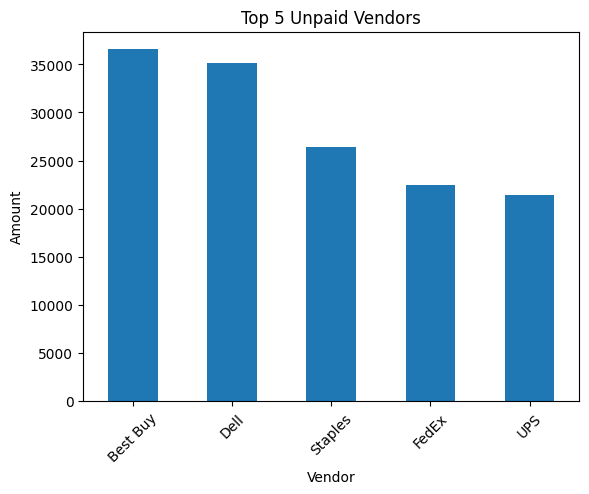

In [13]:
# Visualizing the top 5 unpaid vendors

import matplotlib.pyplot as plt

top_5_unpaid = unpaid_vendors.head(5)

top_5_unpaid.set_index('vendor')['unpaid_amount'].plot(kind='bar')
plt.title('Top 5 Unpaid Vendors')
plt.xlabel('Vendor')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

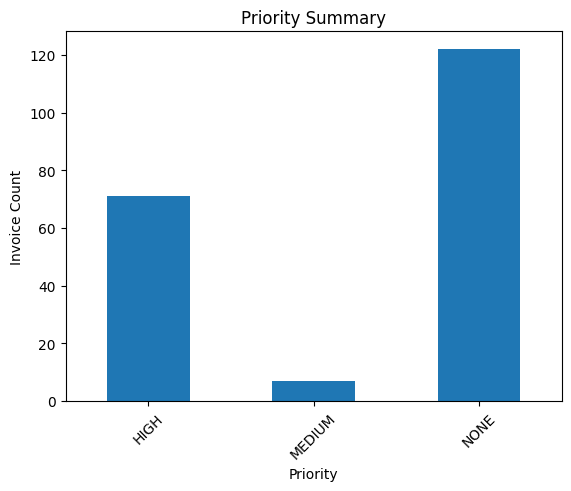

In [16]:
# Visualizing the invoice count by priority level

priority_summary.set_index('priority')['total_count'].plot(kind='bar')
plt.title('Priority Summary')
plt.xlabel('Priority')
plt.ylabel('Invoice Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Insights Found

# Best Buy and Dell have both the highest unpaid totals and unpaid invoice counts making them the highest risk exposure vendors and should be handled immediately.

# There are 77 high priority invoices representing 38% ot the total invoices indicating a possible issue in an area of the process and requires examination and review.